# Zero-Shot Learning Experiments: Latent Embeddings

Using https://joeddav.github.io/blog/2020/05/29/ZSL.html#A-latent-embedding-approach

### 1. Load 5 countries' sentences

In [2]:
import pandas as pd
import sys

sys.path.append("../../")
sys.path.append("../../../")
from tasks.data_loader.src.utils import *

In [3]:
def country_labeled_sentences(excel_map):
    result = {}
    sent_num = 0
    
    for country, dataframe in excel_map.items():

        new_sents_col = dataframe["Sentence"].dropna()
        new_labels_col= dataframe["Primary Instrument"].dropna()
        
        sentences = list(new_sents_col.apply(lambda x: x.replace("\n", "").strip()))
        label_col = new_labels_col.apply(lambda x: x.replace("(PES)", "").replace("(Bond)", "").strip())
        labels = [[string.strip() for string in label.split(", ")][0] for label in label_col]
        result[country] = {}

        for sent, label in zip(sentences, labels):
            if sent_num not in result[country]:
                result[country][sent_num] = {"text": sent, "labels": [label]}
            else:
                result[country][sent_num]["text"] = sent
                result[country][sent_num]["labels"] = [label]
            
            sent_num += 1
            
    return result

def sentences_from_model_output(model_preds):
    return [preds["text"] for preds in model_preds.values()]

In [4]:
data_excel = pd.read_excel("../input/WRI_Policy_Tags.xlsx", engine="openpyxl", sheet_name=None)

In [5]:
all_labeled_sentences = country_labeled_sentences(data_excel)
label_names = ['Credit',
 'Direct payment',
 'Fine',
 'General incentive',
 'Guarantee',
 'Supplies',
 'Tax deduction',
 'Technical assistance',
 'Unknown']

In [6]:
mexico_sents = sentences_from_model_output(all_labeled_sentences['Mexico'])

In [7]:
mexico_labels = labels_from_model_output(all_labeled_sentences['Mexico'])

In [8]:
labeled_sents = dict()

for sents in all_labeled_sentences.values():
    labeled_sents.update(sents)

In [9]:
all_sents = sentences_from_model_output(labeled_sents)
all_labels = labels_from_model_output(labeled_sents)
label_names = list(set(all_labels))

In [10]:
all_sents[:2], all_labels[:2]

(['Generar empleo y garantizara la población campesina el bienestar y su participación e incorporación en el desarrollo nacional, y fomentará la actividad agropecuaria y forestal para el óptimo uso de la tierra, con obras de infraestructura, insumos, créditos, servicios de capacitación y asistencia técnica',
  'El Programa incentivará a los sujetos agrarios a establecer sistemas productivos agroforestales, el cual combina la producción de los cultivos tradicionales en conjunto con árboles frutícolas y maderables, y el sistema de Milpa Intercalada entre Árboles Frutales (MIAF), con lo que se contribuirá a generar empleos, se incentivará la autosuficiencia alimentaria, se mejorarán los ingresos de las y los pobladores y se recuperará la cobertura forestal de un millón de hectáreas en el país.'],
 ['Technical assistance', 'General incentive'])

### 2. Write out latent embedding algorithm

#### Step 1. Take the top K most frequent words V in the vocabulary of a word2vec model

In [11]:
import spacy
from collections import Counter

In [12]:
en_nlp = spacy.load('en_core_web_md')
es_nlp = spacy.load('es_core_news_md')

In [13]:
sents_as_str = ". ".join(mexico_sents)

In [14]:
doc = es_nlp(sents_as_str)

In [15]:
# all tokens that arent stop words or punctuations
words = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct and len(token.text) > 3]

In [16]:
# 20 most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common(20)

In [17]:
top_20_words = list(list(zip(*common_words))[0])

In [18]:
top_20_words

['forestales',
 'forestal',
 'apoyos',
 'manejo',
 'servicios',
 'recursos',
 'programa',
 'desarrollo',
 'ambientales',
 'apoyo',
 'económicos',
 'plantaciones',
 'sustentable',
 'conservación',
 'derecho',
 'promover',
 'actividades',
 'producción',
 'impulsar',
 'incentivos']

#### Step 2. Obtain embeddings for each word using word2vec, $\Phi_{word}(V)$

In [19]:
word2vec_embeddings = []

for word in top_20_words:
    doc = es_nlp(word)
    vector = doc.vector
    word2vec_embeddings.append(vector.reshape(1, 300))

In [20]:
word2vec_embeddings[5].shape

(1, 300)

#### Step 3. Obtain embeddings for each word using S-BERT, $\Phi_{sent}(V)$

In [21]:
from sentence_transformers import SentenceTransformer

/home/davids/miniconda3/envs/wri/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [22]:
model = SentenceTransformer('xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

In [23]:
sbert_embeddings = []

for word in top_20_words:
    vector = model.encode([word], convert_to_numpy=True)
    sbert_embeddings.append(vector)

In [24]:
sbert_embeddings[5].shape

(1, 768)

#### Step 4. Learn a least-squares linear projection matrix Z with L2 regularization from $\Phi_{sent}(V)$ to $\Phi_{word}(V)$

In [25]:
import numpy as np

In [26]:
stacked_sbert = np.vstack(sbert_embeddings)
stacked_word2vec = np.vstack(word2vec_embeddings)

In [27]:
stacked_sbert.shape, stacked_word2vec.shape

((20, 768), (20, 300))

In [28]:
# Help from: https://stackoverflow.com/questions/27476933/numpy-linear-regression-with-regularization and https://www.kdnuggets.com/2016/11/linear-regression-least-squares-matrix-multiplication-concise-technical-overview.html
# Multiple Linear Regression with OLS parameter estimation with L2 regularization term
lamda = 0.01  # lambda = 0 is equivalent to OLS estimation without regularization
Z = np.linalg.inv(stacked_sbert.T.dot(stacked_sbert) + lamda*np.eye(stacked_sbert.shape[1])).dot(stacked_sbert.T).dot(stacked_word2vec)

In [29]:
Z, Z.shape

(array([[-0.05296201,  0.05583028,  0.05234827, ..., -0.04079495,
          0.04818742, -0.04946214],
        [-0.04508072,  0.04923975,  0.04925937, ...,  0.02819155,
         -0.00223869,  0.01609013],
        [ 0.03526131, -0.0139571 ,  0.02116227, ...,  0.01315127,
         -0.04021973,  0.00149297],
        ...,
        [-0.02402237,  0.01069963, -0.01340641, ..., -0.01896711,
          0.02472438,  0.00564341],
        [-0.01575286, -0.03905317, -0.04087726, ..., -0.01780724,
         -0.02433198,  0.00514585],
        [ 0.02127699, -0.02751969, -0.02669438, ...,  0.00879955,
          0.00394906,  0.0195331 ]]), (768, 300))

#### Step 5. Use $Z$ in our classification as an additional transformation to S-BERT embeddings

$$ \hat{c} = arg\,min\,cos(\Phi_{sent}(x)Z, \Phi_{sent}(c)Z)$$

In [30]:
import torch
from torch.nn import functional as F

In [31]:
sentence = 'Quien sera el presidente en 2020?'
labels = ['negocios', 'cultura', 'politica']

In [32]:
sentence_rep = torch.from_numpy(np.matmul(model.encode(sentence), Z)).reshape(1,300)
label_reps = torch.from_numpy(np.matmul(model.encode(labels), Z))

In [33]:
sentence_rep.shape, label_reps.shape

(torch.Size([1, 300]), torch.Size([3, 300]))

In [34]:
similarities = F.cosine_similarity(sentence_rep, label_reps)
closest = similarities.argsort(descending=True)
for ind in closest:
    print(f'label: {labels[ind]} \t similarity: {similarities[ind]}')

label: cultura 	 similarity: 0.18015918187601748
label: politica 	 similarity: -0.05529046115675037
label: negocios 	 similarity: -0.13342647902291316


In [35]:
print(closest)

tensor([1, 2, 0])


#### Step 6. Build functions for the process!

In [36]:
def top_k_words(k, document, spacy_model, include_labels=None):
    doc = spacy_model(sents_as_str)
    
    # all tokens that arent stop words or punctuations and are longer than 3 letters
    words = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct and len(token.text) > 3]
    
    # k most common tokens
    word_freq = Counter(words)
    common_words = word_freq.most_common(k)
    
    result = list(list(zip(*common_words))[0])
    
    if include_labels:
        result.extend(include_labels)
    
    return result


def top_k_word_embeddings(top_k_words, spacy_model):
    word_embeddings = []

    for word in top_k_words:
        doc = spacy_model(word)
        vector = doc.vector
        word_embeddings.append(vector.reshape(1, vector.shape[0]))
        
    return word_embeddings


def top_k_sbert_embeddings(top_k_words, sbert_model):
    sbert_embeddings = []

    for word in top_k_words:
        vector = sbert_model.encode([word], convert_to_numpy=True)
        sbert_embeddings.append(vector)
    
    return sbert_embeddings


def least_squares_with_reg(X, y, lamda=0.01):
    # Help from: https://stackoverflow.com/questions/27476933/numpy-linear-regression-with-regularization and https://www.kdnuggets.com/2016/11/linear-regression-least-squares-matrix-multiplication-concise-technical-overview.html
    # Multiple Linear Regression with OLS parameter estimation with L2 regularization term. lambda = 0 is equivalent to OLS estimation without regularization
    return np.linalg.inv(X.T.dot(X) + lamda*np.eye(X.shape[1])).dot(X.T).dot(y)


def calc_proj_matrix(sentences, k, spacy_model, sbert_model, lamda=0.01, include_labels=None):
    sents_as_str = ". ".join(sentences)
    top_words = top_k_words(k, sents_as_str, spacy_model, include_labels)
    word_emb = np.vstack(top_k_word_embeddings(top_words, spacy_model))
    sent_emb = np.vstack(top_k_sbert_embeddings(top_words, sbert_model))
    proj_matrix = least_squares_with_reg(sent_emb, word_emb, lamda)
    
    return proj_matrix

def encode_sentence(sentence, model, Z):
    sentence_rep = torch.from_numpy(np.matmul(model.encode(sentence), Z))
    sentence_rep = sentence_rep.reshape(1, sentence_rep.shape[0])
    return sentence_rep

def encode_labels(labels, model, Z):
    return torch.from_numpy(np.matmul(model.encode(labels), Z))

def classify_sentence(sentence, labels, model, Z):
    sentence_rep = encode_sentence(sentence, model, Z)
    label_reps = encode_labels(labels, model, Z)
    
    similarities = F.cosine_similarity(sentence_rep, label_reps)
    closest = similarities.argsort(descending=True)
    
    top_index = closest[0]
    return labels[top_index], similarities[top_index]

def classify_sentence_given_label_reps(sentence, label_names, label_reps, model, Z):
    sentence_rep = encode_sentence(sentence, model, Z)
    
    similarities = F.cosine_similarity(sentence_rep, label_reps)
    closest = similarities.argsort(descending=True)
    
    top_index = closest[0]
    return label_names[top_index], similarities[top_index]

def classify_all_sentences(all_sents, label_names, sbert_model, proj_matrix):
    model_preds, model_scores = [], []
    label_reps = encode_labels(label_names, sbert_model, proj_matrix)

    for sent in tqdm(all_sents):
        pred, score = classify_sentence_given_label_reps(sent, label_names, label_reps, sbert_model, proj_matrix)
        model_preds.append(pred)
        model_scores.append(score)
        
    return model_preds, model_scores

#### Step 7. Time to play on our data!

In [37]:
from tqdm import tqdm
from tasks.evaluate_model.src.model_evaluator import *

In [38]:
sbert_model = SentenceTransformer('xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

In [39]:
model_preds, model_scores = [], []

for mexico_sent in tqdm(mexico_sents):
    pred, score = classify_sentence(mexico_sent, label_names, sbert_model, Z)
    model_preds.append(pred)
    model_scores.append(score)

100%|██████████| 211/211 [01:25<00:00,  2.46it/s]


In [40]:
evaluator = ModelEvaluator(label_names)

In [41]:
num_multi_labels = labels_to_numeric(mexico_labels, label_names)
num_multi_preds = labels_to_numeric(model_preds, label_names)

In [42]:
num_multi_labels[:10], num_multi_preds[:10]

([6, 3, 4, 6, 1, 1, 4, 3, 6, 6], [7, 7, 4, 6, 7, 4, 7, 7, 5, 6])

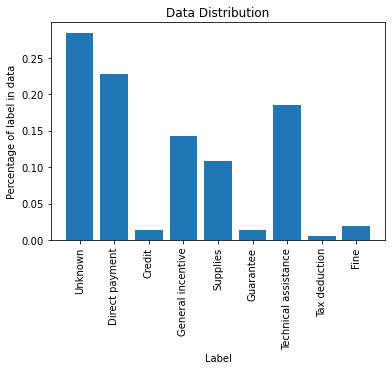

Label counts:
{'Unknown': 0.2843601895734597, 'Direct payment': 0.22748815165876776, 'Credit': 0.014218009478672985, 'General incentive': 0.14218009478672985, 'Supplies': 0.10900473933649289, 'Guarantee': 0.014218009478672985, 'Technical assistance': 0.1848341232227488, 'Tax deduction': 0.004739336492890996, 'Fine': 0.018957345971563982}


In [43]:
plot_data_distribution(num_multi_labels, label_names)

/home/davids/miniconda3/envs/wri/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Stored confusion matrix: ../output/multi_class_test_cm.png


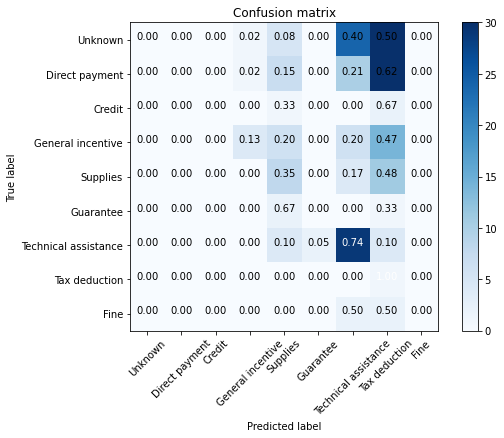

Stored results: ../output/multi_class_test_results.csv


,Precision,Recall (Sensitivity),True negative rate (Specificity),F1-score
Unknown,0,0,1,0
Direct payment,0,0,1,0
Credit,0,0,1,0
General incentive,0.67,0.13,0.99,0.22
Supplies,0.24,0.35,0.87,0.29
Guarantee,0,0,0.99,0
-----,-----,-----,-----,-----
Technical assistance,0.39,0.74,0.73,0.51
Tax deduction,0.01,1,0.55,0.02
Fine,0,0,1,0


In [44]:
evaluator.evaluate(num_multi_labels, num_multi_preds, 
                   plot_cm=True, normalize=True, 
                   store=True, exp_name="multi_class_test")

Stored Precision-Recall Curve: multi_class_test_prc.png


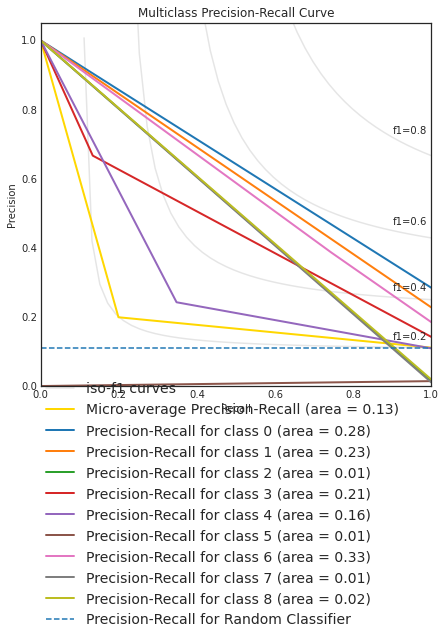

In [45]:
evaluator.plot_precision_recall_curve(num_multi_labels, num_multi_preds, bin_class=False, all_classes=True, store=True, exp_name="multi_class_test")

## Further Experiments

### Things to play around with
- Labels
    - [x] Mix credit and guarantee together 
    - [x] Take out general incentive and unknown 
    - [ ] Replace unknown with something else?
- [x] Visualize embeddings 
- Embeddings
    - [x] Include the labels in the Z matrix process
    - [ ] Different values of lamda for projection matrix (for regulatization)
    - [ ] Learn an additional least-squares projection matrix to the embeddings of any available labels from their corresponding data embeddings (as described in the *When some annotated data is available* section of the base article)
    - Top k words 
        - [ ] Different values of k for top k words
        - [ ] Use more words for k words, and use the stems of the word 
- [ ] Model type for sentence embeddings
- [ ] Model type for word embeddings?
- [ ] Fine tuning sentence model

### Initial setup

In [45]:
# Setup - Get projection matrix and define model
sbert_model = SentenceTransformer('xlm-r-100langs-bert-base-nli-stsb-mean-tokens')
proj_matrix = calc_proj_matrix(all_sents, 50, es_nlp, sbert_model, 0.1)
all_sents = sentences_from_model_output(labeled_sents)
all_labels = labels_from_model_output(labeled_sents)
label_names = list(set(all_labels))

### Experiment 1. Merge Credit and Guarantee

In [46]:
def merge_labels(all_labels, labels_to_merge):
    return [f"{labels_to_merge[0]} & {labels_to_merge[1]}" if label in labels_to_merge else label for label in all_labels]

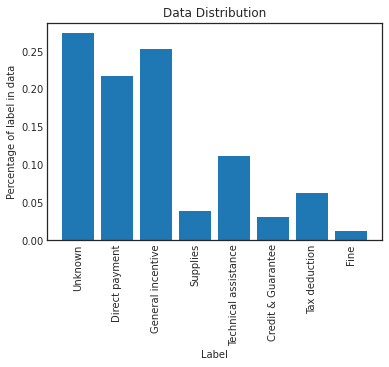

Label counts:
{'Unknown': 0.273972602739726, 'Direct payment': 0.2176560121765601, 'General incentive': 0.2526636225266362, 'Supplies': 0.0395738203957382, 'Technical assistance': 0.1111111111111111, 'Credit & Guarantee': 0.030441400304414, 'Tax deduction': 0.0624048706240487, 'Fine': 0.0121765601217656}


In [47]:
all_labels = merge_labels(all_labels, ["Credit", "Guarantee"]) 
label_names = list(set(all_labels))
num_labels = labels_to_numeric(all_labels, label_names)
plot_data_distribution(num_labels, label_names)

In [48]:
model_preds, model_scores = classify_all_sentences(all_sents, label_names, sbert_model, proj_matrix)
num_preds = labels_to_numeric(model_preds, label_names)

100%|██████████| 657/657 [01:52<00:00,  5.82it/s]


In [49]:
evaluator = ModelEvaluator(label_names)

/home/davids/miniconda3/envs/wri/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Stored confusion matrix: ../output/latent_emb_exp1_cm.png


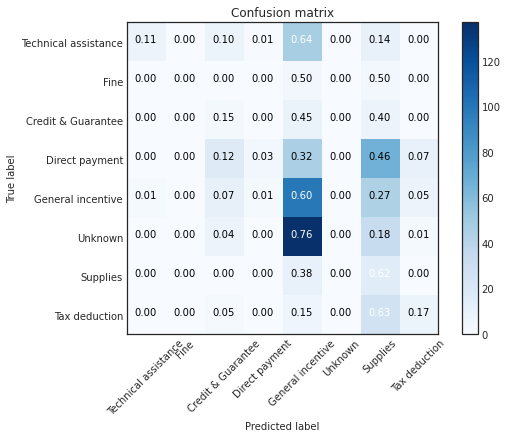

Stored results: ../output/latent_emb_exp1_results.csv


,Precision,Recall (Sensitivity),True negative rate (Specificity),F1-score
Technical assistance,0.8,0.11,1,0.19
Fine,0,0,1,0
Credit & Guarantee,0.06,0.15,0.93,0.09
Direct payment,0.57,0.03,0.99,0.05
General incentive,0.28,0.6,0.47,0.38
Unknown,0,0,1,0
-----,-----,-----,-----,-----
Supplies,0.08,0.62,0.7,0.14
Tax deduction,0.26,0.17,0.97,0.21
Macro avg,0.26,0.21,0.88,0.13


In [50]:
evaluator.evaluate(num_labels, num_preds, 
                   plot_cm=True, normalize=True, 
                   store=True, exp_name="latent_emb_exp1")

/home/davids/miniconda3/envs/wri/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Stored Precision-Recall Curve: latent_emb_exp1_prc.png


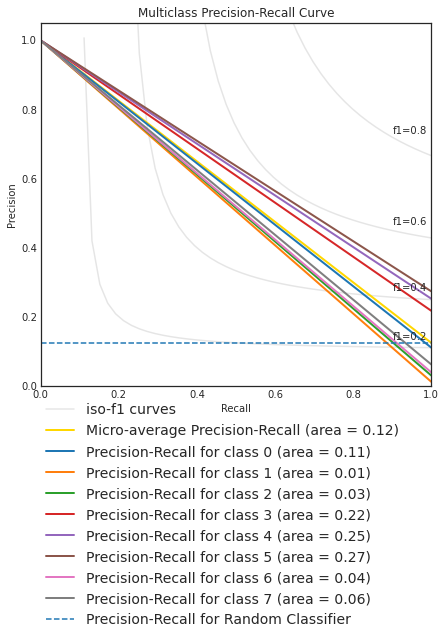

In [51]:
evaluator.plot_precision_recall_curve(num_labels, model_preds, bin_class=False, all_classes=True, store=True, exp_name="latent_emb_exp1")

### Experiment 2. Get rid of Unknown and General incentive, and merge Credit and Guarantee

In [48]:
filtered_sents_maps = [sent for sent in labeled_sents.values() if sent['labels'][0] not in ["General incentive", "Unknown"]]
all_sents = [sent['text'] for sent in filtered_sents_maps]
all_labels = [sent['labels'][0] for sent in filtered_sents_maps]
all_labels = merge_labels(all_labels, ["Credit", "Guarantee"]) 
label_names = list(set(all_labels))
label_names

['Direct payment',
 'Supplies',
 'Technical assistance',
 'Credit & Guarantee',
 'Tax deduction',
 'Fine']

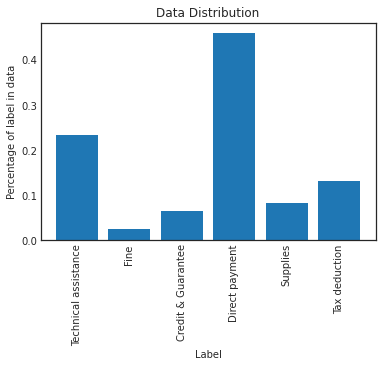

Label counts:
{'Technical assistance': 0.2347266881028939, 'Fine': 0.02572347266881029, 'Credit & Guarantee': 0.06430868167202572, 'Direct payment': 0.45980707395498394, 'Supplies': 0.08360128617363344, 'Tax deduction': 0.13183279742765272}


In [53]:
num_labels = labels_to_numeric(all_labels, label_names)
plot_data_distribution(num_labels, label_names)

In [54]:
model_preds, model_scores = classify_all_sentences(all_sents, label_names, sbert_model, proj_matrix)
num_preds = labels_to_numeric(model_preds, label_names)

100%|██████████| 311/311 [00:52<00:00,  5.98it/s]


In [55]:
evaluator = ModelEvaluator(label_names)

/home/davids/miniconda3/envs/wri/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Stored confusion matrix: ../output/latent_emb_exp2_cm.png


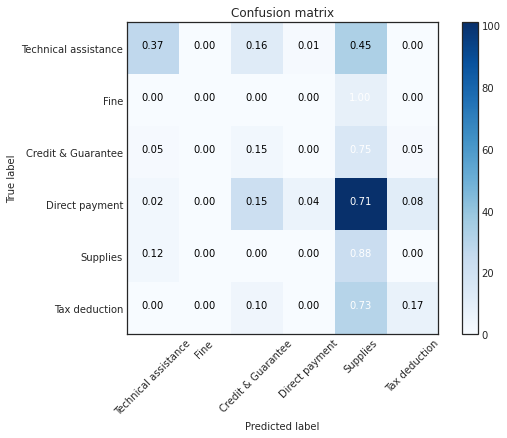

Stored results: ../output/latent_emb_exp2_results.csv


,Precision,Recall (Sensitivity),True negative rate (Specificity),F1-score
Technical assistance,0.79,0.37,0.97,0.5
Fine,0,0,1,0
Credit & Guarantee,0.07,0.15,0.87,0.1
Direct payment,0.86,0.04,0.99,0.08
Supplies,0.11,0.88,0.34,0.19
Tax deduction,0.37,0.17,0.96,0.23
-----,-----,-----,-----,-----
Macro avg,0.37,0.27,0.86,0.19
Weighted avg,0.64,0.21,0.92,0.21
Accuracy,-----,-----,-----,0.21221864951768488


In [56]:
evaluator.evaluate(num_labels, num_preds, 
                   plot_cm=True, normalize=True, 
                   store=True, exp_name="latent_emb_exp2")

/home/davids/miniconda3/envs/wri/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Stored Precision-Recall Curve: latent_emb_exp2_prc.png


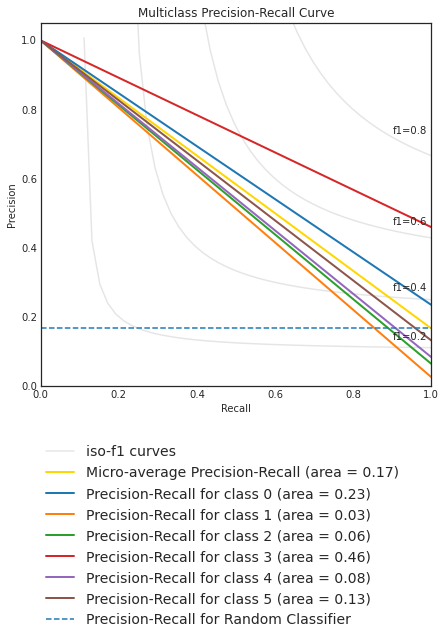

In [57]:
evaluator.plot_precision_recall_curve(num_labels, model_preds, bin_class=False, all_classes=True, store=True, exp_name="latent_emb_exp2")

### Experiment 3. Visualizing data (Setup from experiment 2.)

In [49]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [50]:
sbert_model = SentenceTransformer('stsb-xlm-r-multilingual')
proj_matrix = calc_proj_matrix(all_sents, 50, es_nlp, sbert_model, 0.01)
all_sent_embs = np.vstack([encode_sentence(sent, sbert_model, proj_matrix) for sent in all_sents])
df = pd.DataFrame()
df["y"] = np.array(num_labels)
all_sent_embs.shape, len(df["y"])

((311, 300), 657)

In [51]:
def visualize_embeddings(embs, numeric_labels, tsne_perplexity, pca_k_n_comps=None, seed=69420):
    df = pd.DataFrame()
    df["y"] = np.array(numeric_labels)
    num_labels = len(set(numeric_labels))
    
    # Data for plot 1
    pca = PCA(n_components=2, random_state=seed)
    pca_result = pca.fit_transform(embs)
    df['pca-1'] = pca_result[:,0]
    df['pca-2'] = pca_result[:,1] 
    
    # Data for plot 2
    tsne = TSNE(n_components=2, verbose=1, perplexity=tsne_perplexity, n_iter=1000, random_state=seed)
    tsne_results = tsne.fit_transform(embs)
    df["tsne-1"] = tsne_results[:,0]
    df["tsne-2"] = tsne_results[:,1]
    
    # Actual plotting
    plt.figure(figsize=(24, 4))
    ax1 = plt.subplot(1, 3, 1)
    sns.scatterplot(
        x="pca-1", y="pca-2",
        hue=df.y.tolist(),
        palette="bright",
        data=df,
        legend=False,
        ax=ax1
    ).set(title="PCA projection")
    
    ax2 = plt.subplot(1, 3, 2)
    sns.scatterplot(
        x="tsne-1", y="tsne-2",
        hue=df.y.tolist(),
        palette="bright",
        data=df,
        legend=False if pca_k_n_comps else "auto",
        ax=ax2
    ).set(title="t-SNE projection")
    
    if pca_k_n_comps:
        # Data for plot 3
        pca_k = PCA(n_components=pca_k_n_comps, random_state=seed)
        pca_k_result = pca_k.fit_transform(embs)
        tsne_pca_results = tsne.fit_transform(pca_k_result)
        df[f"tsne-pca-{pca_k_n_comps}-1"] = tsne_pca_results[:,0]
        df[f"tsne-pca-{pca_k_n_comps}-2"] = tsne_pca_results[:,1]
        
        # Actual plotting
        ax3 = plt.subplot(1, 3, 3)
        sns.scatterplot(
            x=f"tsne-pca-{pca_k_n_comps}-1", y=f"tsne-pca-{pca_k_n_comps}-2",
            hue=df.y.tolist(),
            palette="bright",
            data=df,
            ax=ax3
        ).set(title="t-SNE on PCA projection")

    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 311 samples in 0.016s...
[t-SNE] Computed neighbors for 311 samples in 0.177s...
[t-SNE] Computed conditional probabilities for sample 311 / 311
[t-SNE] Mean sigma: 9.759052
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.032410
[t-SNE] KL divergence after 1000 iterations: 0.912552


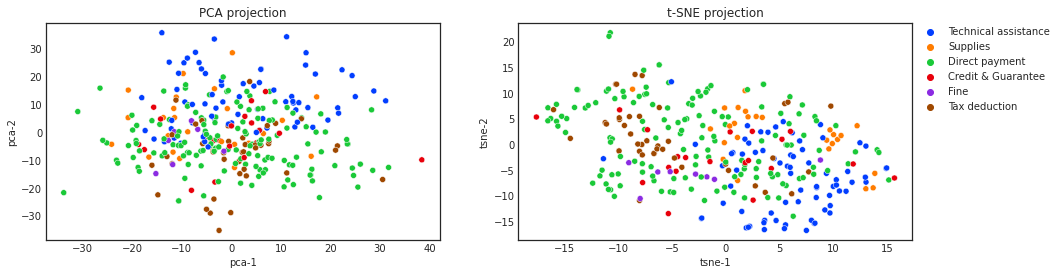

In [52]:
visualize_embeddings(all_sent_embs, all_labels, tsne_perplexity=40)

### Experiment 4. Include the labels in the Z matrix process (Setup from experiment 2.)

In [62]:
proj_matrix = calc_proj_matrix(all_sents, 50, es_nlp, sbert_model, 0.1, include_labels=label_names)

In [63]:
model_preds, model_scores = classify_all_sentences(all_sents, label_names, sbert_model, proj_matrix)
num_preds = labels_to_numeric(model_preds, label_names)

100%|██████████| 311/311 [00:55<00:00,  5.59it/s]


In [64]:
evaluator = ModelEvaluator(label_names)

Stored confusion matrix: ../output/latent_emb_exp3_cm.png


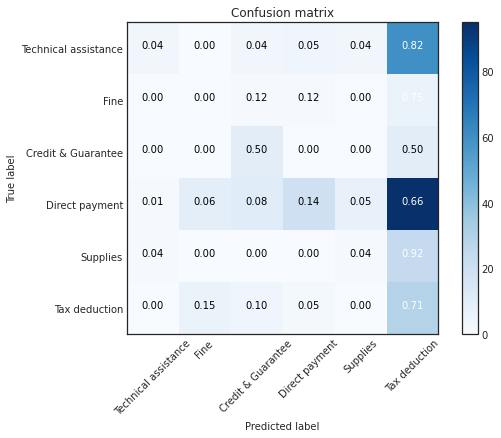

Stored results: ../output/latent_emb_exp3_results.csv


,Precision,Recall (Sensitivity),True negative rate (Specificity),F1-score
Technical assistance,0.6,0.04,0.99,0.08
Fine,0,0,0.95,0
Credit & Guarantee,0.34,0.5,0.93,0.41
Direct payment,0.74,0.14,0.96,0.24
Supplies,0.09,0.04,0.96,0.05
Tax deduction,0.13,0.71,0.28,0.22
-----,-----,-----,-----,-----
Macro avg,0.32,0.24,0.85,0.17
Weighted avg,0.53,0.2,0.88,0.19
Accuracy,-----,-----,-----,0.20257234726688103


In [65]:
evaluator.evaluate(num_labels, num_preds, 
                   plot_cm=True, normalize=True, 
                   store=True, exp_name="latent_emb_exp3")

/home/davids/miniconda3/envs/wri/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Stored Precision-Recall Curve: latent_emb_exp3_prc.png


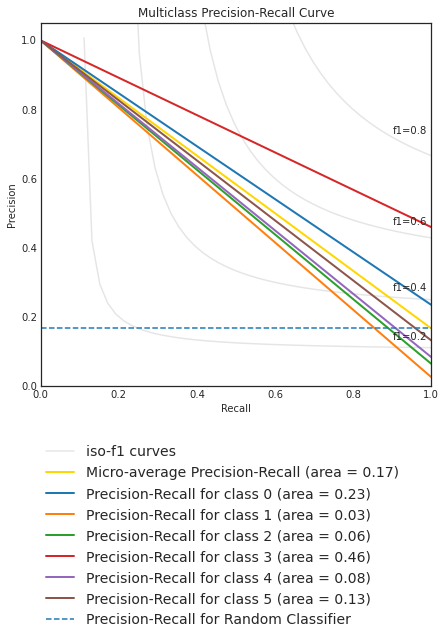

In [66]:
evaluator.plot_precision_recall_curve(num_labels, model_preds, bin_class=False, all_classes=True, store=True, exp_name="latent_emb_exp3")

### Experiment 5.  Fine tune sentence embedding model (Setup from experiment 2.)
The FineTuning folder that contains the fine-tuned model is located on Google Drive under the folder WRI-LatinAmerica-Talent/Modeling/FineTuning. To execute the following code you should download this folder to tasks/augment_data/output/FineTuning.

In [54]:
# Load the saved model and obtain random sentence embedding
model_save_path = "../output/FineTuning"
load_model = SentenceTransformer(model_save_path)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 311 samples in 0.017s...
[t-SNE] Computed neighbors for 311 samples in 0.168s...
[t-SNE] Computed conditional probabilities for sample 311 / 311
[t-SNE] Mean sigma: 4.697683
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.978302
[t-SNE] KL divergence after 1000 iterations: 0.263768


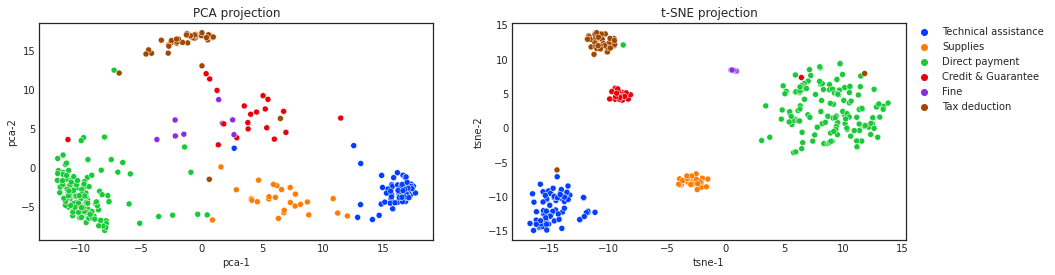

In [55]:
# Simple low-dim projection
all_sent_embs = np.vstack([load_model.encode(sent) for sent in all_sents])
visualize_embeddings(all_sent_embs, all_labels, tsne_perplexity=40)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 311 samples in 0.005s...
[t-SNE] Computed neighbors for 311 samples in 0.081s...
[t-SNE] Computed conditional probabilities for sample 311 / 311
[t-SNE] Mean sigma: 7.201386
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.336075
[t-SNE] KL divergence after 1000 iterations: 0.379202


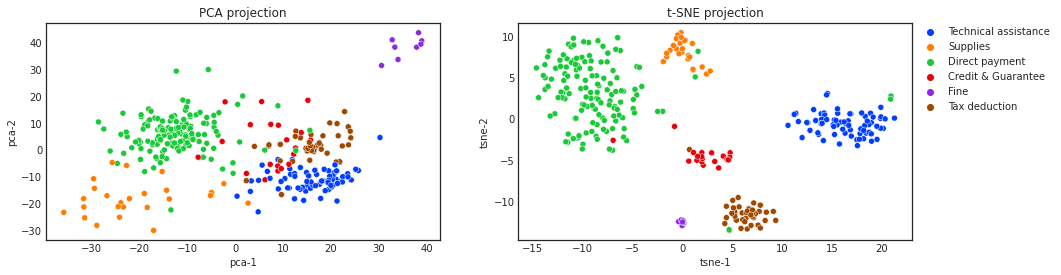

In [56]:
# Projection matrix Z low-dim projection
proj_matrix = calc_proj_matrix(all_sents, 50, es_nlp, load_model, 0.01)
all_sent_embs = np.vstack([encode_sentence(sent, load_model, proj_matrix) for sent in all_sents])
visualize_embeddings(all_sent_embs, all_labels, tsne_perplexity=40)

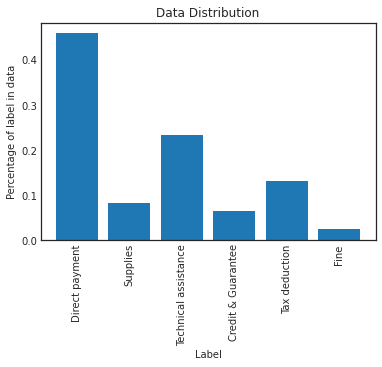

Label counts:
{'Direct payment': 0.45980707395498394, 'Supplies': 0.08360128617363344, 'Technical assistance': 0.2347266881028939, 'Credit & Guarantee': 0.06430868167202572, 'Tax deduction': 0.13183279742765272, 'Fine': 0.02572347266881029}


In [75]:
num_labels = labels_to_numeric(all_labels, label_names)
plot_data_distribution(num_labels, label_names)

In [76]:
# Classify all sentences
model_preds, model_scores = classify_all_sentences(all_sents, label_names, load_model, proj_matrix)
num_preds = labels_to_numeric(model_preds, label_names)

100%|██████████| 311/311 [01:07<00:00,  4.60it/s]


In [82]:
evaluator = ModelEvaluator(label_names)

Stored confusion matrix: ../output/latent_emb_exp4_cm.png


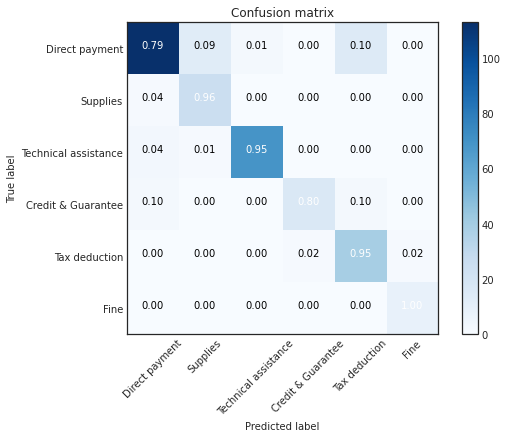

Stored results: ../output/latent_emb_exp4_results.csv


,Precision,Recall (Sensitivity),True negative rate (Specificity),F1-score
Direct payment,0.95,0.79,0.96,0.86
Supplies,0.64,0.96,0.95,0.77
Technical assistance,0.97,0.95,0.99,0.96
Credit & Guarantee,0.94,0.8,1,0.86
Tax deduction,0.7,0.95,0.94,0.8
Fine,0.89,1,1,0.94
-----,-----,-----,-----,-----
Macro avg,0.85,0.91,0.97,0.87
Weighted avg,0.89,0.87,0.97,0.87
Accuracy,-----,-----,-----,0.8681672025723473


In [83]:
evaluator.evaluate(num_labels, num_preds, 
                   plot_cm=True, normalize=True, 
                   store=True, exp_name="latent_emb_exp4")

/home/davids/miniconda3/envs/wri/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Stored Precision-Recall Curve: latent_emb_exp4_prc.png


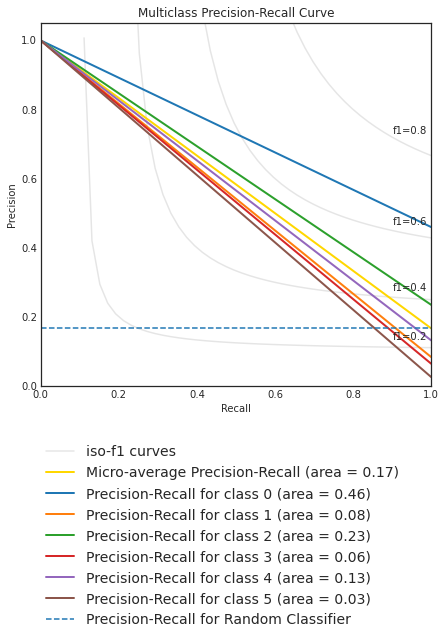

In [84]:
evaluator.plot_precision_recall_curve(num_labels, model_preds, bin_class=False, all_classes=True, store=True, exp_name="latent_emb_exp4")